### Extract Rooms from IFC and plot them

IFC file opened successfully.
Number of IfcSpaces found: 193
Number of IfcSpaces matching storey 'Plan 10': 37
Number of IfcSpaces with valid names: 30


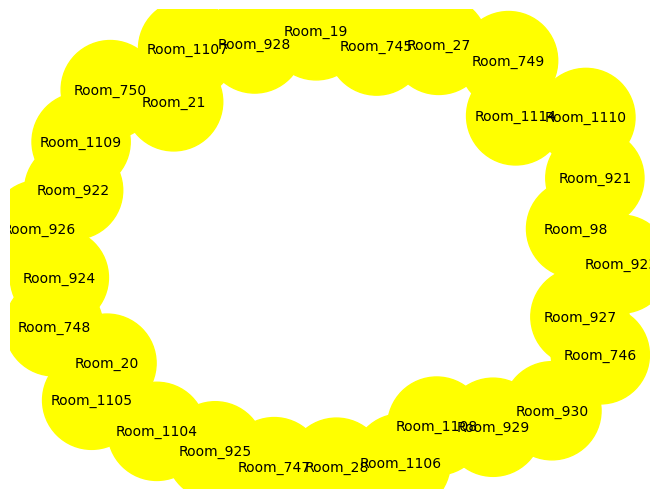

In [6]:
import ifcopenshell
import re
import networkx as nx
import matplotlib.pyplot as plt

def load_ifc_file(file_path):
    """Load the IFC file."""
    return ifcopenshell.open(file_path)

def filter_ifcspaces_by_storey(spaces, storey_name):
    """Filter IfcSpaces by the given storey name."""
    filtered_spaces = []
    for space in spaces:
        for rel in space.Decomposes:
            if rel.is_a("IfcRelAggregates") and rel.RelatingObject.is_a("IfcBuildingStorey"):
                if rel.RelatingObject.Name == storey_name:
                    filtered_spaces.append(space)
                    break
    return filtered_spaces

def filter_spaces_by_name(spaces):
    """Filter IfcSpaces by name containing only digits (1-5 digits)."""
    digit_pattern = re.compile(r'^\d{1,5}$')
    filtered_spaces = []
    for space in spaces:
        if digit_pattern.match(space.Name):
            filtered_spaces.append(space)
    return filtered_spaces

# -- MAIN --

# Load the IFC file
ifc_file = load_ifc_file("Hus28_test.ifc")
print("IFC file opened successfully.")

# Define the storey name to filter
storey_name = "Plan 10"

# Find all IfcSpaces
all_spaces = ifc_file.by_type("IfcSpace")
num_spaces = len(all_spaces)
print(f"Number of IfcSpaces found: {num_spaces}")

# Filter spaces by the specified storey name
spaces = filter_ifcspaces_by_storey(all_spaces, storey_name)
num_filtered_spaces = len(spaces)
print(f"Number of IfcSpaces matching storey '{storey_name}': {num_filtered_spaces}")

# Further filter spaces by names containing only digits (1-5 digits)
spaces = filter_spaces_by_name(spaces)
num_filtered_by_name = len(spaces)
print(f"Number of IfcSpaces with valid names: {num_filtered_by_name}")

# Create a NetworkX graph
G = nx.Graph()

# Add nodes to the graph
for space in spaces:
    node_label = f"Room_{space.Name}"
    G.add_node(node_label, color='yellow')

# Draw the graph
colors = [G.nodes[node]['color'] for node in G.nodes]
nx.draw(G, with_labels=True, node_color=colors, node_size=5000, font_size=10, font_color='black')
plt.show()


### Add direct Contact between Rooms

In [10]:
import pandas as pd
import plotly.graph_objs as go

# Load the CSV file
csv_file = "Output01_RoomsBySeparationLine.csv"

# Manually read and parse the CSV file
edges = []
with open(csv_file, 'r') as file:
    for line in file:
        rooms = line.strip().split(';')
        main_room = rooms[0]
        for neighbor in rooms[1:]:
            edges.append((main_room, neighbor))

# Add edges to the graph
for edge in edges:
    room1 = f"Room_{edge[0]}"
    room2 = f"Room_{edge[1]}"
    if room1 in G and room2 in G:
        G.add_edge(room1, room2, Access="Direct")

# Calculate node positions
pos = nx.spring_layout(G)

# Prepare nodes and edges for Plotly
edge_trace = []
for edge in G.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace.append(go.Scatter(x=[x0, x1, None], y=[y0, y1, None],
                                 line=dict(width=1, color='blue' if edge[2]['Access'] == 'Direct' else 'black'),
                                 hoverinfo='none', mode='lines'))

node_trace = go.Scatter(x=[pos[node][0] for node in G.nodes], y=[pos[node][1] for node in G.nodes],
                        text=[node for node in G.nodes], mode='markers+text',
                        textposition='top center', hoverinfo='text',
                        marker=dict(showscale=False, color='yellow', size=10, line_width=2))

# Create Plotly figure
fig = go.Figure(data=edge_trace + [node_trace],
                layout=go.Layout(showlegend=False, hovermode='closest',
                                 margin=dict(b=20, l=5, r=5, t=40),
                                 xaxis=dict(showgrid=False, zeroline=False),
                                 yaxis=dict(showgrid=False, zeroline=False)))

fig.show()


### Add Contact via Doors

In [14]:
# Load the second CSV file
csv_file_doors = "Output02_RoomsByDoors.csv"

# Manually read and parse the second CSV file
door_edges = []
with open(csv_file_doors, 'r') as file:
    for line in file:
        rooms = line.strip().split(';')
        if len(rooms) > 3:
            print(f"Door {rooms[0]} connects more than two rooms: {rooms[1:]}")
        if len(rooms) > 1:
            for i in range(1, len(rooms) - 1):
                for j in range(i + 1, len(rooms)):
                    door_edges.append((rooms[i], rooms[j]))

# Add door edges to the graph
for edge in door_edges:
    room1 = f"Room_{edge[0]}"
    room2 = f"Room_{edge[1]}"
    if room1 in G and room2 in G:
        G.add_edge(room1, room2, Access="Door")

# Calculate node positions
pos = nx.spring_layout(G)

# Prepare nodes and edges for Plotly
edge_trace = []
for edge in G.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    color = 'blue' if edge[2]['Access'] == 'Direct' else 'green' if edge[2]['Access'] == 'Door' else 'black'
    edge_trace.append(go.Scatter(x=[x0, x1, None], y=[y0, y1, None],
                                 line=dict(width=1, color=color),
                                 hoverinfo='none', mode='lines'))

node_trace = go.Scatter(x=[pos[node][0] for node in G.nodes], y=[pos[node][1] for node in G.nodes],
                        text=[node for node in G.nodes], mode='markers+text',
                        textposition='top center', hoverinfo='text',
                        marker=dict(showscale=False, color='yellow', size=10, line_width=2))

# Create Plotly figure
fig = go.Figure(data=edge_trace + [node_trace],
                layout=go.Layout(showlegend=False, hovermode='closest',
                                 margin=dict(b=20, l=5, r=5, t=40),
                                 xaxis=dict(showgrid=False, zeroline=False),
                                 yaxis=dict(showgrid=False, zeroline=False)))

fig.show()



Door 36670 connects more than two rooms: ['750', '750', '928']


### Add Doors

In [18]:
# Load the second CSV file
csv_file_doors = "Output02_RoomsByDoors.csv"

# Manually read and parse the second CSV file
door_edges = []
doors = set()
with open(csv_file_doors, 'r') as file:
    for line in file:
        rooms = line.strip().split(';')
        door = rooms[0]
        doors.add(door)
        if len(rooms) > 3:
            print(f"Door {door} connects more than two rooms: {rooms[1:]}")
        if len(rooms) > 1:
            for room in rooms[1:]:
                door_edges.append((door, room))

# Add door nodes to the graph
for door in doors:
    G.add_node(f"Door_{door}", color='blue')

# Add door edges to the graph
for edge in door_edges:
    door = f"Door_{edge[0]}"
    room = f"Room_{edge[1]}"
    if room in G:
        G.add_edge(door, room, IsConnected=True)

# Calculate node positions
pos = nx.spring_layout(G)

# Prepare nodes and edges for Plotly
edge_trace = []
for edge in G.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    color = 'blue' if edge[2].get('Access') == 'Direct' else 'green' if edge[2].get('Access') == 'Door' else 'red' if edge[2].get('IsConnected') else 'black'
    edge_trace.append(go.Scatter(x=[x0, x1, None], y=[y0, y1, None],
                                 line=dict(width=1, color=color),
                                 hoverinfo='none', mode='lines'))

node_trace = go.Scatter(x=[pos[node][0] for node in G.nodes], y=[pos[node][1] for node in G.nodes],
                        text=[node for node in G.nodes], mode='markers+text',
                        textposition='top center', hoverinfo='text',
                        marker=dict(showscale=False, color=[G.nodes[node]['color'] for node in G.nodes], size=10, line_width=2))

# Create Plotly figure
fig = go.Figure(data=edge_trace + [node_trace],
                layout=go.Layout(showlegend=False, hovermode='closest',
                                 margin=dict(b=20, l=5, r=5, t=40),
                                 xaxis=dict(showgrid=False, zeroline=False),
                                 yaxis=dict(showgrid=False, zeroline=False)))

fig.show()

Door 36670 connects more than two rooms: ['750', '750', '928']
